## Introduction
The aim of this project is to train a classifier that can predict if passengers of the Titanic survived based on the features available in the dataset.

## Imports

In [75]:
import pandas as pd
import seaborn as sns

## Import Data

In [76]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [77]:
# Inspect the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Definition of features
- PassengerId: Unique identifier for each passenger
- Survived: The target feature - 0 means the passenger did not survive, 1 means they did
- Pclass: The passenger class of the ship
- Name, sex, age: Self-explanatory
- SibSp: How many siblings & spouses the passenger had aboard
- Parch: How many children & parents of the passenger aboard
- Ticket: Ticket id
- Fare: Price paid in pounds
- Cabin: The passenger's cabin number
- Embarked: Where the passenger embarked the ship

## Data Cleaning

Let's start by using the passenger id as the index for both datasets.

In [78]:
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


We can see we have missing data for the age, cabin and embarked attributes. Cabin is missing values on a large number of instances, so for now, we will drop the cabin feature. For age, we will look to impute missing values. 

In [80]:
# Drop cabin feature
train.drop(columns=['Cabin'], axis=1, inplace=True)

### Imputing missing values for age
We will start by seeing how the median age varies by class, as this may be a better method of imputation rather than using a single value for all classes.

In [81]:
# Inspect how many unique classes exist
train['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

We see 3 different classes exist: 1, 2 and 3. We will look at how the median age varies across each class next.

In [82]:
# Function to create a dictionary of classes and respective median ages
def median_age_by_class():
    median_age_dict = {}
    for p_class in train['Pclass'].unique():
        median_age = train[train['Pclass'] == p_class]['Age'].median()
        print(f'Class {p_class} median age: {median_age}')
        median_age_dict[p_class] = median_age
    return median_age_dict

median_age_dict = median_age_by_class()

Class 3 median age: 24.0
Class 1 median age: 37.0
Class 2 median age: 29.0


In [83]:
# Check the median age dictionary
median_age_dict

{3: 24.0, 1: 37.0, 2: 29.0}

We see there is significant variation in median passenger age by class. We will use these median age values for imputation.

In [84]:
# Fill nan values by mapping to median age dictionary with Pclass
train['Age'] = train['Age'].fillna(train['Pclass'].map(median_age_dict))

We next need to handle missing values for 'Embarked'. As there are only 2 missing values, we will use the most common boarding location: S.

In [85]:
# Inspect boarding location counts
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [86]:
train['Embarked'] = train['Embarked'].fillna('S')

We can now check the null counts again to make sure our imputation was successful.

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


## EDA

### Basics
We'll start by looking at the numeric features.

In [88]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.066405,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.244540,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- We can see from the above only 38% of passengers survived
- The mean age of passengers was 29
- The mean fare was £32.20

### Correlation & Correlation Matrix

In [92]:
train.corr(numeric_only=True)['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.047255
Pclass     -0.338481
Name: Survived, dtype: float64

<Axes: >

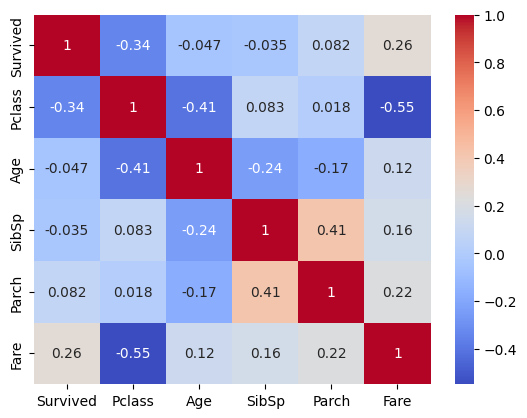

In [89]:
sns.heatmap(train.corr(numeric_only=True), cmap='coolwarm', annot=True)

- We see the strongest correlation with survival is passenger class - a negative correlation
- Fare has the second strongest correlation, this time positive
- All other numeric feature show relatively weak correlation with survival
- It is likely the passenger class and fare overlap somewhat, as they are inherantly linked, so would likely benefit from feature reduction